In [14]:
import matplotlib.pyplot as plt
from os import getcwd
import torch
from torch.distributions import multivariate_normal

from algorithm_package.algorithm_package import paper_algorithm
from energy_package.energy_package import two_param
from rf_package.rf_package import planar_flow
from rf_package.rf_package import other_flows
from plot_animation_package.plot_animation_package import density_2D

from os.path import dirname

In [15]:
import torch
from torch.distributions.uniform import Uniform

class MultivariateUniform(Uniform):
    def __init__(self, low, high, data_dim):
        super(MultivariateUniform, self).__init__(low, high)
        self.data_dim = data_dim

    def sample(self):
        return super().sample(torch.Size([self.data_dim]))

    def log_prob(self, value):
        if value.size(-1) != self.data_dim:
            raise ValueError("Last dimension of value must be of size data_dim")

        # Calculate log_prob for each dimension and sum them
        log_prob_per_dim = super().log_prob(value)
        return log_prob_per_dim.sum(-1)


In [71]:
def plot(beta, U, BC, energy_parameters, model_file, normalization_flow, base_distribution):

    flow = normalization_flow
    flow.load_state_dict(torch.load(model_file+'\\model.pt'))
    flow.eval()

    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,5))

    xlim = [-15,15]
    ylim = xlim
    x = torch.linspace(* xlim,200)
    y = torch.linspace(*ylim,200)

    xx, yy = torch.meshgrid(x,y)
    
    def log_rho_hat(x):
        return base_distribution.log_prob(BC((flow.inverse(x))[0])) + flow.inverse(x)[1]

    z_flow = torch.exp(log_rho_hat(torch.stack([xx, yy], dim=-1).reshape(-1, 2)).detach()).reshape(xx.shape)
    z_flow_norm = z_flow / torch.sum(z_flow)+1e-15
    
    ax1.pcolormesh(xx.numpy(),yy.numpy(),torch.log(z_flow_norm).numpy())
    ax1.set_title('Flow distribution (logscale)')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')

    z_target = torch.exp(-beta*U(torch.stack([xx, yy]), energy_parameters))
    z_target_norm = z_target / torch.sum(z_target)+1e-15
    
    ax2.pcolormesh(xx.numpy(),yy.numpy(),torch.log(z_target_norm).numpy())
    ax2.set_title('Target distribution (logscale)')
    ax2.set_xlabel('x')

    # Compute KL Divergence
    #kl_div = torch.sum(z_flow_norm * torch.log(z_flow_norm / z_target_norm))
    
    fig.savefig(model_file+'\\PDF_logscale.png')

    return None

In [76]:
# MODEL PARAMETERS
data_dim = 2 #size of the parameter space
beta = 1
U = two_param.bistable_circle
BC = two_param.bistable_circle_BC
energy_parameters = []

# RF PARAMETERS
#base_distribution = multivariate_normal.MultivariateNormal(loc=torch.zeros(data_dim), covariance_matrix=torch.eye(data_dim))
base_distribution = MultivariateUniform(-20, 20, data_dim)
normalization_flow = planar_flow.LayeredPlanarFlow(data_dim, flow_length=16)
#layers = 4
#mask = torch.randint(0, 2, (data_dim,))
#masks = [torch.randint(0, 2, (data_dim,)) for _ in range(layers)]
#hidden_size = 4
#normalization_flow = other_flows.LayeredSimpleAffine(data_dim, flow_length=16)

epsilon = 2e-2 #gradient descent rate for RF parameters
n = 20 #number of initial samples

# MALA PARAMETERS
time_step = 1e-1
k_lang = 10
k_max = 200

# INITIALISATION
initial_data = torch.rand(n*data_dim).reshape(n,data_dim)*20-10

base_file = 'multivariate_uniform-LayeredSimpleAffine'
model_name = base_file
model_file = getcwd()+"\\saved_models"+"\\"+model_name

RF_MCMC_parameters = [time_step, k_max, k_lang, epsilon]
#history, array_of_model_configurations = paper_algorithm.NF_MCMC_algorithm(model_name, beta, U, BC, energy_parameters, normalization_flow, initial_data, base_distribution, *RF_MCMC_parameters)

#plot(beta, U, BC, energy_parameters, model_file, normalization_flow, base_distribution)



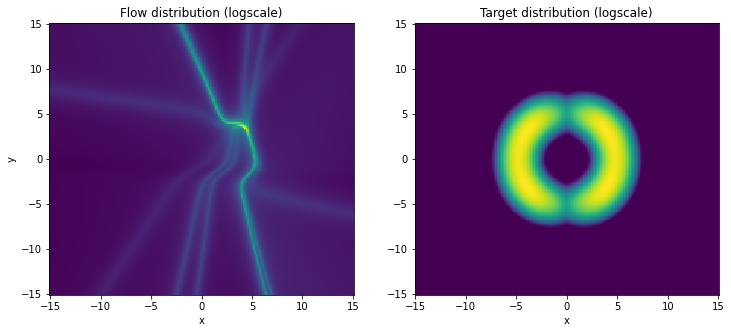

In [77]:
base_file = 'multivariate_uniform-LayeredPlanarFlow-translated'
model_name = base_file
model_file = getcwd()+"\\saved_models"+"\\"+model_name

plot(beta, U, BC, energy_parameters, model_file, normalization_flow, base_distribution)

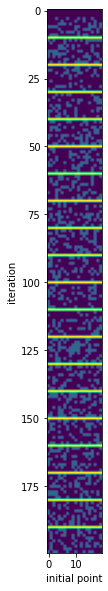

In [61]:
model_file = getcwd()+"\\saved_models"+"\\"+model_name

history = torch.load(model_file + '\\history.pt').detach()

fig, ax = plt.subplots(figsize = (5,10))
ax.imshow(history)
ax.set_xlabel('initial point')
ax.set_ylabel('iteration')
fig.savefig(model_file + '\\history.png')

MovieWriter imagemagick unavailable; using Pillow instead.


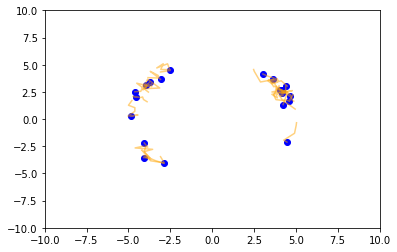

In [62]:
density_2D.animation(model_file, n, k_max, array_of_model_configurations, history)